In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ultralytics import YOLO
import os
import sys
sys.path.insert(0, '../')

In [2]:
from onnx_model import ImageToWordModel
from mltu.configs import BaseModelConfigs

In [3]:
from dotenv import load_dotenv, find_dotenv
import google.generativeai as genai

In [4]:
image_path = '../sample_images/a01-000u.png'
lines_model = YOLO('../models/detect_lines.pt')
words_model = YOLO('../models/detect_words.pt')

configs = BaseModelConfigs.load('../models/configs.yaml')
classify_word_model = ImageToWordModel(model_path='../models/classify_word.onnx', char_list=configs.vocab)

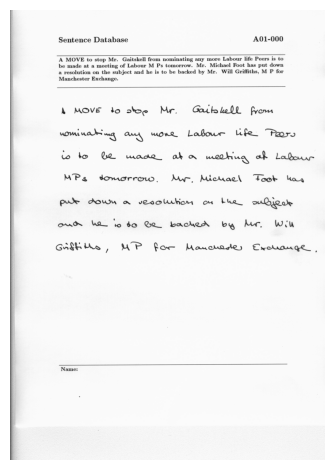

In [5]:
image = cv2.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.tight_layout()

In [6]:
def prepare_image(image):
  h,w = image.shape[:2]
  new_size = max(h,w) + 200

  padded_image = np.full((new_size, new_size, 3), (255,255,255), dtype=np.uint8)
  x_offset = (new_size-w)//2
  y_offset = (new_size-h)//2

  padded_image[y_offset:y_offset+h, x_offset:x_offset+w] = image
  return padded_image

In [7]:
def detect_lines(padded_image):
  results = lines_model.predict(padded_image, conf=0.1, iou=0.3)
  coords = []
  output_lines = []

  for result in results:
    for box in result.boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])
      coords.append([x1,y1,x2,y2])
  
  coords = sorted(coords, key=lambda x:x[1])

  for coord in coords:
    x1,y1,x2,y2 = coord
    output_lines.append(padded_image[y1:y2, x1:x2])
    # cv2.rectangle(padded_image, (x1,y1), (x2,y2), (255,0,0), 1)

  return output_lines


(-0.5, 3741.5, 3741.5, -0.5)

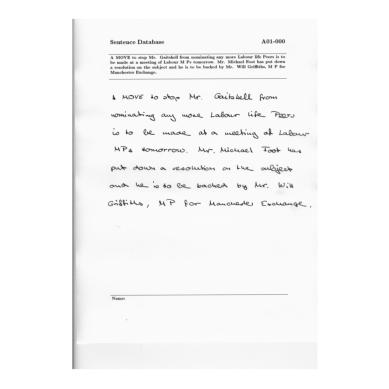

In [8]:
image = prepare_image(image)
plt.imshow(image)
plt.axis('off')

In [9]:
lines_output = detect_lines(image)



0: 640x640 8 Lines, 326.6ms
Speed: 6.4ms preprocess, 326.6ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


(-0.5, 3741.5, 3741.5, -0.5)

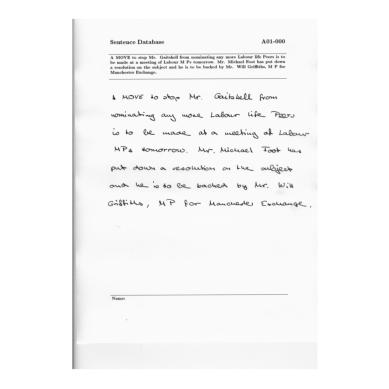

In [10]:
plt.imshow(image)
plt.axis('off')

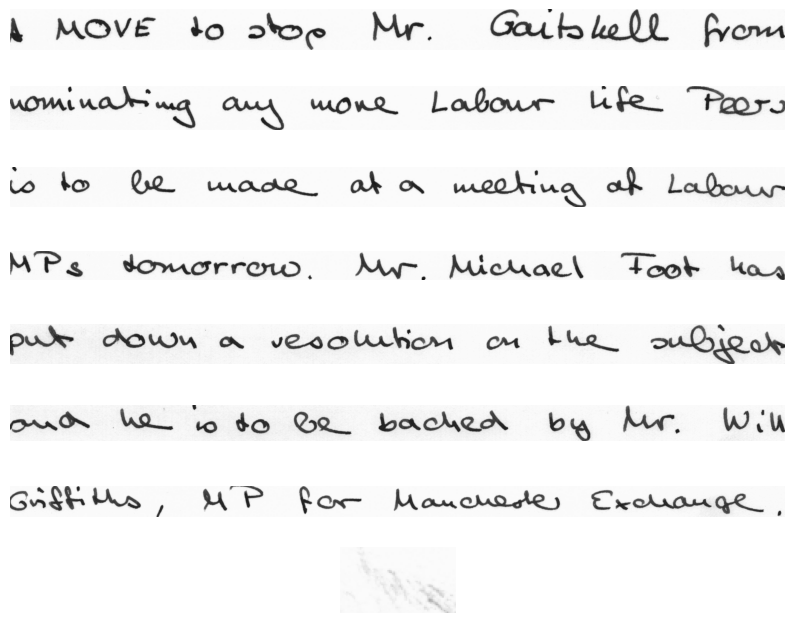

In [11]:
rows = len(lines_output)
cols = 1
k = 0
fig,axs = plt.subplots(rows, cols, figsize=(10*cols, rows))
for i in range(rows):
  axs[i].imshow(lines_output[k])
  axs[i].axis('off')
  k+=1

In [12]:
def detect_words(lines):
  words = []

  for line in lines:
    coords = []
    results = words_model.predict(line, conf=0.1, iou=0.001)
    for result in results:
      for box in result.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        if (x2-x1 < 7) | (y2-y1 < 7):
          continue
        coords.append([x1,y1,x2,y2])
    
    coords = sorted(coords, key=lambda x:x[0])
    for coord in coords:
      x1,y1,x2,y2 = coord
      words.append(line[y1:y2, x1:x2])
  
  return words



0: 64x640 7 Texts, 79.9ms
Speed: 0.8ms preprocess, 79.9ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 6 Texts, 39.8ms
Speed: 1.8ms preprocess, 39.8ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 9 Texts, 33.9ms
Speed: 0.6ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 640)

0: 32x640 6 Texts, 19.9ms
Speed: 0.6ms preprocess, 19.9ms inference, 0.3ms postprocess per image at shape (1, 3, 32, 640)

0: 64x640 7 Texts, 30.0ms
Speed: 1.0ms preprocess, 30.0ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 32x640 11 Texts, 21.1ms
Speed: 0.7ms preprocess, 21.1ms inference, 0.3ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 9 Texts, 21.3ms
Speed: 0.9ms preprocess, 21.3ms inference, 0.3ms postprocess per image at shape (1, 3, 32, 640)

0: 384x640 7 Texts, 167.5ms
Speed: 1.5ms preprocess, 167.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


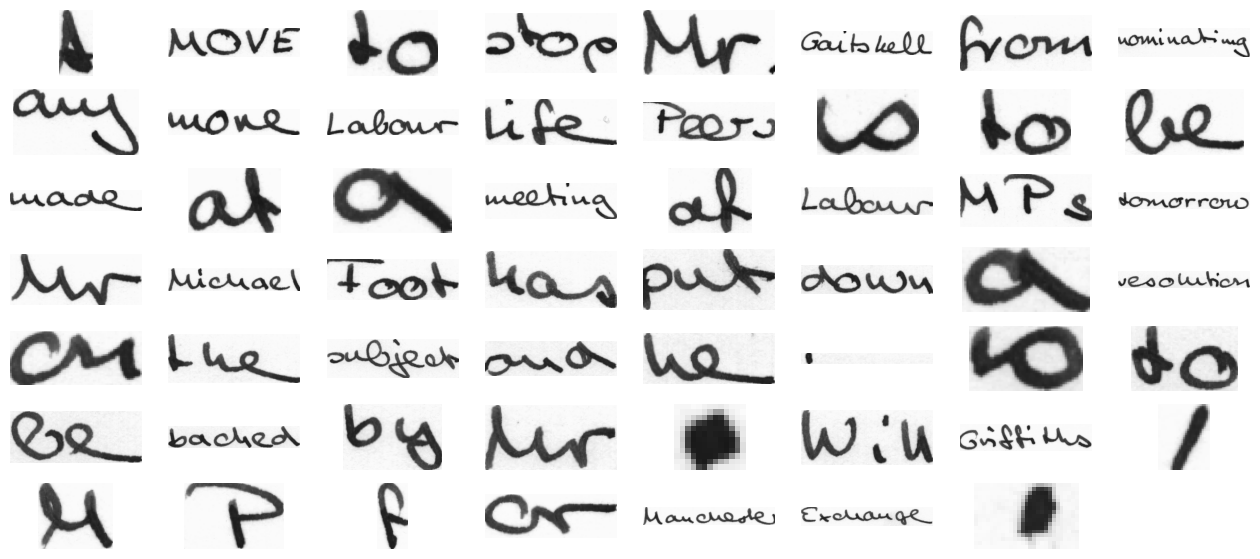

In [13]:
words_output = detect_words(lines_output)

cols = 8
rows = len(words_output)//cols+1
k = 0
fig,axs = plt.subplots(rows, cols, figsize=(2*cols, rows))
for i in range(rows):
  for j in range(cols):
    if k < len(words_output):
      axs[i][j].imshow(words_output[k])
      axs[i][j].axis('off')
      k+=1
    else:
      axs[i][j].axis('off')

In [14]:
def predict_words(words):
  output = ''
  for word in words:
    prediction = classify_word_model.predict(word)

    output += (prediction + ' ')

  return output 

In [15]:
prediction = predict_words(words_output)

In [16]:
prediction

'A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers o to be made at a meeting of Labour Ps tomorrow the Michael toot has put down a resolution on the subject and he . so to be backed by Mr . will Griffiths , A , , or Manchestr Exchange . '

In [17]:
load_dotenv(find_dotenv())
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

In [18]:
genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel('gemini-1.5-flash')

In [19]:
prompt = f'''You will be given an input with potential typos, misspellings, and bad autocorrection: {prediction}.
Return ONLY the input after fixing any potential errors.'''

response = gemini_model.generate_content(prompt)

In [20]:
response.text

'A move to stop Mr. Gaitskell from nominating any more Labour life peers is to be made at a meeting of Labour MPs tomorrow. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, MP for Manchester Exchange.\n'